# X5

In [132]:
import random

import numpy as np
import pandas as pd

import torch

torch.cuda.empty_cache()

def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [133]:
SEED = 42
# seed_all(SEED)

In [134]:
# torch.cuda.reset_peak_memory_stats()
# torch.cuda.empty_cache()

In [135]:
from pathlib import Path

DATA_PATH = Path('../../../data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH_DOWNLOAD = DATA_PATH / Path('download/')
DATA_PATH_DOWNLOAD.mkdir(parents=True, exist_ok=True)

DATA_PATH_DATASET = DATA_PATH / Path('datasets/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_SYNTHETICS = DATA_PATH / Path('synthetics/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_CACHE = DATA_PATH / Path('cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = DATA_PATH / Path('models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

DATA_IMGS = DATA_PATH /  Path('imgs/')
DATA_IMGS.mkdir(parents=True, exist_ok=True)

import pandas as pd

pd.set_option('display.max_colwidth', 500) 

In [136]:
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_path)

In [137]:
BASE_MODEL_NAME = 'cointegrated/rubert-tiny2'
# BASE_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME_SAVE = "ner_x5"
MODEL_CHECKPOINT_PATH = "ner_x5_checkpoint"

In [138]:
from datetime import datetime

current_date = datetime.now().strftime("%d-%m-%Y")
DATA_LOG = DATA_PATH / Path(f'../logs/{MODEL_NAME_SAVE}_{current_date}')
DATA_LOG.mkdir(parents=True, exist_ok=True)

In [139]:
MAX_LENGTH = 8
BATCH_SIZE = 128

# Данные

In [140]:
df_x5 = pd.read_csv(DATA_PATH_DATASET / "train.csv", sep=";")

df_x5.sample(5)

,sample,annotation
25928,чипсы сметана и лук,"[(0, 5, 'B-TYPE'), (6, 13, 'O'), (14, 15, 'O'), (16, 19, 'O')]"
5893,готлеты,"[(0, 7, 'B-TYPE')]"
23547,томатны,"[(0, 7, 'B-TYPE')]"
27142,яйцох,"[(0, 5, 'B-TYPE')]"
21540,спрей jund,"[(0, 5, 'B-TYPE'), (6, 10, 'B-BRAND')]"


In [141]:
def normalize_annotations(ann_list):
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    new_list = []
    for start, end, label in ann_list:
        if label == "0":
            label = "O"
        new_list.append((start, end, label))
    return new_list

df_x5["annotation"] = df_x5["annotation"].apply(normalize_annotations)

In [142]:
all_labels = set()

for ann_list in df_x5["annotation"]:
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    for _, _, label in ann_list:
        all_labels.add(label)

unique_labels = sorted(all_labels)
unique_labels

['B-BRAND',
 'B-PERCENT',
 'B-TYPE',
 'B-VOLUME',
 'I-BRAND',
 'I-PERCENT',
 'I-TYPE',
 'I-VOLUME',
 'O']

In [143]:
df_x5.sample(5)

,sample,annotation
13654,мосло,"[(0, 5, B-TYPE)]"
17795,прочая губ,"[(0, 6, B-TYPE), (7, 10, I-TYPE)]"
20344,сливвки,"[(0, 7, B-TYPE)]"
10400,крабовыеи,"[(0, 9, B-TYPE)]"
2310,vлаваш,"[(0, 6, B-BRAND)]"


In [144]:
df_submission = pd.read_csv(DATA_PATH_DATASET / "submission.csv", sep=";")
df_submission["annotation"] = df_submission["annotation"].apply(normalize_annotations)

In [145]:
import pandas as pd
from pathlib import Path
import ast

def load_synthetic_file(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            try:
                text, ann_str = line.split(";", 1)
                text = text.strip()
                annotation = ast.literal_eval(ann_str.strip())
                data.append({"sample": text, "annotation": annotation})
            except Exception as e:
                print(f"Ошибка при обработке строки в {file_path}: {line}\n{e}")

    return pd.DataFrame(data)


In [146]:
def load_synthetic_dataset(data_dir: str | Path) -> pd.DataFrame:
    data_dir = Path(data_dir)
    all_dfs = []

    for file_path in data_dir.glob("*.txt"):
        df_file = load_synthetic_file(file_path)
        all_dfs.append(df_file)

    if all_dfs:
        return pd.concat(all_dfs).reset_index(drop=True)
    else:
        return pd.DataFrame(columns=["sample", "annotation"])


In [147]:
df_synthetic = load_synthetic_dataset(DATA_SYNTHETICS)

Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: молоко простоквашино 3.2% 1 л и хлеб дарницкий 400 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 6, "B-TYPE"), (7, 19, "B-BRAND"), (20, 24, "B-PERCENT"), (25, 28, "B-VOLUME"), (31, 35, "B-TYPE"), (36, 45, "B-BRAND"), (46, 51, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: кефир валио 1% 930 г и сыр президент 45% 200 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 5, "B-TYPE"), (6, 11, "B-BRAND"), (12, 14, "B-PERCENT"), (15, 20, "B-VOLUME"), (23, 26, "B-TYPE"), (27, 36, "B-BRAND"), (37, 41, "B-PERCENT"), (42, 47, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: шоколад милка 90 г и печенье юбилейное 300 г;
invalid syntax (<unknown>, line 0)

In [148]:
df_x5["df_label"] = "x5"
df_synthetic["df_label"] = "synthetic"

dfs = []
dfs.append(df_x5)
dfs.append(df_synthetic)

In [149]:
df_train = pd.concat(dfs, ignore_index=True)
df_train = df_train.drop_duplicates(subset=["sample"]).reset_index(drop=True)

In [150]:
df_synthetic.sample(5)

,sample,annotation,df_label
646,сыр ламберт твердый выдержанный 50% 230 г,"[(0, 3, B-TYPE), (4, 11, B-BRAND), (36, 40, B-PERCENT), (41, 46, B-VOLUME)]",synthetic
1230,холодильник однокамерный индезит,"[(0, 11, B-TYPE), (12, 25, I-TYPE), (26, 33, B-BRAND)]",synthetic
1090,сосиски венскые деликатесные,"[(0, 7, B-TYPE), (8, 15, I-TYPE), (16, 28, I-TYPE)]",synthetic
1446,хлеб кавказскй тонкй,"[(0, 4, B-TYPE), (5, 15, I-TYPE), (16, 22, I-TYPE)]",synthetic
2027,днер,"[(0, 4, B-TYPE)]",synthetic


# Словари

In [151]:
unique_labels = {label for anns in df_train["annotation"] for _, _, label in anns if label != "O"}

b_labels = sorted([lbl for lbl in unique_labels if lbl.startswith("B-")])
i_labels = {lbl[2:]: lbl for lbl in unique_labels if lbl.startswith("I-")}

all_labels = ["O"]
for b in b_labels:
    all_labels.append(b)
    base = b[2:]
    if base in i_labels:
        all_labels.append(i_labels[base])

label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("label2idx:", label2idx)
print("idx2label:", idx2label)


label2idx: {'O': 0, 'B-BRAND': 1, 'I-BRAND': 2, 'B-PERCENT': 3, 'I-PERCENT': 4, 'B-TYPE': 5, 'I-TYPE': 6, 'B-VOLUME': 7, 'I-VOLUME': 8}
idx2label: {0: 'O', 1: 'B-BRAND', 2: 'I-BRAND', 3: 'B-PERCENT', 4: 'I-PERCENT', 5: 'B-TYPE', 6: 'I-TYPE', 7: 'B-VOLUME', 8: 'I-VOLUME'}


In [152]:
import json

label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "w", encoding="utf-8") as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=4)

with open(idx2label_path, "w", encoding="utf-8") as f:
    json.dump(idx2label, f, ensure_ascii=False, indent=4)

print(f"Словарь label2idx сохранён в {label2idx_path}")
print(f"Словарь idx2label сохранён в {idx2label_path}")

Словарь label2idx сохранён в ..\..\..\data\models\label2idx.json
Словарь idx2label сохранён в ..\..\..\data\models\idx2label.json


# Датасет

In [153]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data: pd.DataFrame
val_data: pd.DataFrame
train_data, val_data = train_test_split(
    df_train,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)


In [154]:
train_data.head()

,sample,annotation,df_label
11699,ломтишк,"[(0, 7, B-TYPE)]",x5
7900,йкра,"[(0, 4, B-TYPE)]",x5
17090,полукопченная,"[(0, 13, B-TYPE)]",x5
14204,напитка,"[(0, 7, B-TYPE)]",x5
28447,мармелад фруктовый бабаевский,"[(0, 8, B-TYPE), (9, 18, I-TYPE), (19, 29, B-BRAND)]",synthetic


In [155]:
df_submission.head()

,sample,annotation
0,форма для выпечки,"[(0, 5, B-TYPE), (6, 9, I-TYPE), (10, 17, I-TYPE)]"
1,фарш свиной,"[(0, 4, B-TYPE), (5, 11, I-TYPE)]"
2,сок ананасовый без сахара,"[(0, 3, B-TYPE), (4, 14, I-TYPE), (15, 18, I-TYPE), (19, 25, I-TYPE)]"
3,еринги,"[(0, 6, B-TYPE)]"
4,молооко,"[(0, 7, B-TYPE)]"


In [156]:
from ml.dataset import NerDataSet

dtype_input = torch.long
dtype_labels = torch.long

train_dataset = NerDataSet(
    df=train_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True    
)

val_dataset = NerDataSet(
    df=val_data,
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)

test_dataset = NerDataSet(
    df=df_submission, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)


Tokenizing data: 100%|████████████████████████████████████████| 5000/5000 [00:00<00:00, 9239.01it/s]


In [157]:
test_dataset[0]

{'input_ids': tensor([    2,  9295,   871, 72728,     3,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([   0,    5,    6,    6,    0, -100, -100, -100])}

In [158]:
val_dataset.df.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug
1878,мармеад,"[(0, 7, B-TYPE)]",x5,"[2, 33839, 3277, 5747, 3, 0, 0, 0]","[[CLS], мар, ##ме, ##ад, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O]"
696,зубатка,"[(0, 7, B-TYPE)]",x5,"[2, 38658, 8533, 3, 0, 0, 0, 0]","[[CLS], зуба, ##тка, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O]"
2003,frutees,"[(0, 7, B-BRAND)]",x5,"[2, 1911, 4275, 596, 3, 0, 0, 0]","[[CLS], fr, ##ute, ##es, [SEP], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, I-BRAND, O, O, O, O]"
2776,семечкг,"[(0, 7, B-TYPE)]",x5,"[2, 55028, 1669, 865, 1072, 3, 0, 0]","[[CLS], семе, ##ч, ##к, ##г, [SEP], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]"
1050,blade,"[(0, 5, B-BRAND)]",x5,"[2, 25977, 3, 0, 0, 0, 0, 0]","[[CLS], blade, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, O, O, O, O, O, O]"
898,салат винегрт овощн,"[(0, 6, B-TYPE), (7, 14, I-TYPE), (15, 22, I-TYPE)]",synthetic,"[2, 46610, 48101, 19387, 751, 51355, 679, 3]","[[CLS], салат, вине, ##гр, ##т, овощ, ##н, [SEP]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O]"
1658,рцы,"[(0, 3, O)]",x5,"[2, 328, 2386, 3, 0, 0, 0, 0]","[[CLS], р, ##цы, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, O, O, O, O, O, O, O]"
1453,омарт,"[(0, 5, O)]",x5,"[2, 35956, 14745, 3, 0, 0, 0, 0]","[[CLS], ом, ##арт, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, O, O, O, O, O, O, O]"
1725,сухой корм для кош,"[(0, 5, B-TYPE), (6, 10, I-TYPE), (11, 14, O), (15, 18, O)]",x5,"[2, 39436, 38962, 871, 18397, 1276, 3, 0]","[[CLS], сухой, корм, для, ко, ##ш, [SEP], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O]"
2062,рол фладлия лосось,"[(0, 3, B-TYPE), (4, 12, I-TYPE), (13, 19, I-TYPE)]",synthetic,"[2, 54907, 65591, 41707, 776, 68061, 1725, 3]","[[CLS], рол, фла, ##дли, ##я, лосо, ##сь, [SEP]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O]"


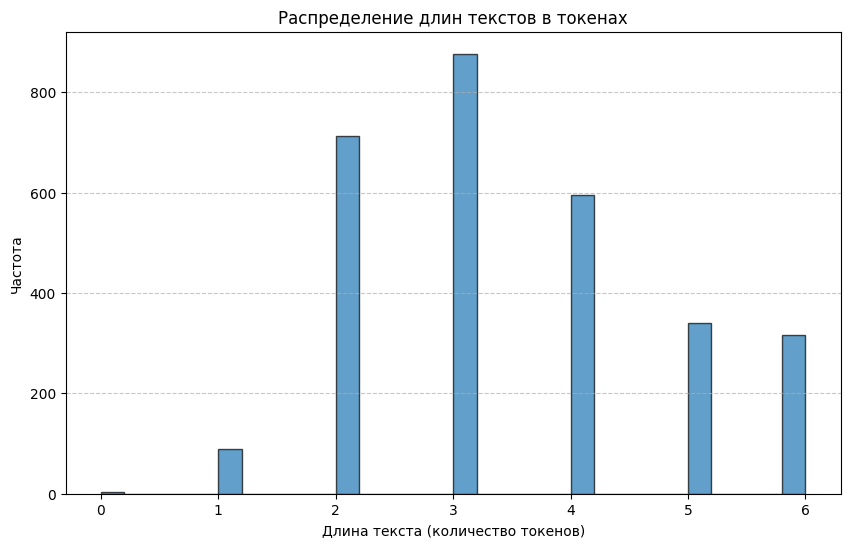

In [159]:
val_dataset.plot_token_length_distribution()

# Модель

In [160]:
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

# # model.gradient_checkpointing_enable()
model.reset_crf_parameters()
model

Some weights of AutoModelForTokenClassificationWithCRF were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['backbone.embeddings.LayerNorm.bias', 'backbone.embeddings.LayerNorm.weight', 'backbone.embeddings.position_embeddings.weight', 'backbone.embeddings.token_type_embeddings.weight', 'backbone.embeddings.word_embeddings.weight', 'backbone.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.encoder.layer.0.attention.output.dense.bias', 'backbone.encoder.layer.0.attention.output.dense.weight', 'backbone.encoder.layer.0.attention.self.key.bias', 'backbone.encoder.layer.0.attention.self.key.weight', 'backbone.encoder.layer.0.attention.self.query.bias', 'backbone.encoder.layer.0.attention.self.query.weight', 'backbone.encoder.layer.0.attention.self.value.bias', 'backbone.encoder.layer.0.attention.self.value.weight', 'backbone.encoder.layer.0.intermediate.dense.bias', '

AutoModelForTokenClassificationWithCRF(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,)

In [161]:
print("CRF transitions nan?", torch.isnan(model.crf.transitions).any())
print("CRF transitions min/max:", model.crf.transitions.min(), model.crf.transitions.max())

CRF transitions nan? tensor(False)
CRF transitions min/max: tensor(-0.0968, grad_fn=<MinBackward1>) tensor(0.0983, grad_fn=<MaxBackward1>)


# Обучение

In [162]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_PATH_SAVE_MODELS / MODEL_CHECKPOINT_PATH,  # Папка для сохранения моделей
    num_train_epochs=10,  # Количество эпох
    # learning_rate=3e-5,
    # max_grad_norm=0.5,

    # eval_strategy="epoch",  # Оценка модели после каждой эпохи
    eval_strategy="steps",
    eval_steps=100,  # Оценка модели каждый шаг
    # logging_strategy="epoch",  # Логирование каждые N шагов
    logging_strategy="steps",
    logging_steps=100,  # Как часто логировать
    disable_tqdm=False,  # Отключить tqdm (нужно для работы в Colab/Kaggle)
    report_to="tensorboard",  # Логируем в TensorBoard
    logging_dir=DATA_LOG,  # Папка для логов

    # save_strategy="epoch",  # Сохранение модели после каждой эпохи
    save_strategy="steps",
    save_steps=100, # Если save_strategy="steps"
    save_total_limit=5,  # Храним все
    load_best_model_at_end=True,  # Загружать лучшую модель после обучения
    metric_for_best_model="eval_f1_macro",  # Выбираем лучшую модель по eval_f1_macro
    greater_is_better=True,  # Чем меньше eval_loss, тем лучше модель


    per_device_train_batch_size=BATCH_SIZE,  # Размер батча на одно устройство (GPU/CPU)
    per_device_eval_batch_size=BATCH_SIZE,  # Размер батча для валидации
)


In [163]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

steps_per_epoch = len(train_dataset.df) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs


In [164]:
# from transformers import get_cosine_schedule_with_warmup

# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.40 * total_steps),
#     num_training_steps=total_steps 
# )

In [165]:
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
    num_cycles=2,
)


In [166]:
# from transformers import get_polynomial_decay_schedule_with_warmup

# scheduler = get_polynomial_decay_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     lr_end=1e-7,
#     power=2.0,
# )


In [167]:
# from transformers import get_constant_schedule_with_warmup

# scheduler = get_constant_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
# )


In [168]:
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1)

In [169]:
from collections import Counter

import numpy as np
import torch
from torch.nn import CrossEntropyLoss


def compute_class_weights(train_dataset, num_labels, max_weight: float = 10.0, smoothing: float = 1.0):
    all_labels = []
    for labels in train_dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)
    counts = Counter(all_labels)
    total = sum(counts.values())
    class_weights = [total / (counts.get(i, 0) + smoothing) for i in range(num_labels)]
    class_weights = np.array(class_weights, dtype=np.float32)
    class_weights = class_weights / class_weights.sum()
    class_weights = np.clip(class_weights, 0.0, max_weight)
    return torch.tensor(class_weights, dtype=torch.float32)

def weighted_crf_loss(
    emissions,
    labels,
    attention_mask,
    crf,
    class_weights_tensor,
    alpha=0.7,
):
    labels_for_crf = labels.clone().long()
    labels_for_crf[labels_for_crf == -100] = 0

    crf_loss = -crf(
        emissions,
        labels_for_crf,
        mask=attention_mask.bool(),
        reduction="token_mean"
    )

    logits_flat = emissions.view(-1, emissions.size(-1))
    labels_flat = labels.view(-1)
    ce_loss_fn = CrossEntropyLoss(
        weight=class_weights_tensor.to(emissions.device),
        ignore_index=-100
    )
    ce_loss = ce_loss_fn(logits_flat, labels_flat)
    total_loss = alpha * crf_loss + (1 - alpha) * ce_loss
    return total_loss


def weighted_loss(
    outputs: "TokenClassifierCRFOutput",
    labels,
    model,
    class_weights_tensor,
    alpha=0.7,
    num_items_in_batch=None,
):
    emissions = outputs.logits
    loss = weighted_crf_loss(
        emissions=emissions,
        labels=labels,
        attention_mask=outputs.attention_mask,
        crf=model.crf,
        class_weights_tensor=class_weights_tensor,
        alpha=alpha,
    )
    return loss


In [170]:
class_weights_tensor = compute_class_weights(train_dataset, num_labels, max_weight=10.0, smoothing=1.0)

In [171]:
from functools import partial

from ml.trainer import CustomBaseTrainer
from ml.metrics import compute_metrics

trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.5)
)

In [172]:
trainer.train()

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Precision,Recall,F1 Micro,F1 Macro,Accuracy
100,1.786900,1.355034,0.474658,0.477787,0.476218,0.148928,0.800188
200,1.022200,1.028034,0.474097,0.605904,0.531958,0.252885,0.831635
300,0.684600,0.719957,0.535815,0.709659,0.610604,0.307361,0.872398
400,0.533100,0.539563,0.609343,0.762683,0.677444,0.477019,0.897530
500,0.362000,0.488576,0.687653,0.807681,0.742850,0.536578,0.913348
600,0.286100,0.473254,0.723019,0.823732,0.770096,0.595231,0.918850
700,0.261100,0.455291,0.731744,0.835770,0.780305,0.607109,0.920038
800,0.201200,0.463799,0.760000,0.844081,0.799837,0.632353,0.926977
900,0.192100,0.446583,0.761892,0.844655,0.801142,0.628363,0.927165
1000,0.174900,0.443355,0.763009,0.848954,0.803690,0.627433,0.928103


d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinne

TrainOutput(global_step=2070, training_loss=0.3292247944983883, metrics={'train_runtime': 540.5412, 'train_samples_per_second': 488.27, 'train_steps_per_second': 3.829, 'total_flos': 30439549422720.0, 'train_loss': 0.3292247944983883, 'epoch': 10.0})

In [173]:
# trainer.plot_results()

In [174]:
test_results = trainer.predict(test_dataset)
print(test_results.metrics)

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 0.5222352743148804, 'test_precision': 0.6645538761579717, 'test_recall': 0.7517926089354661, 'test_f1_micro': 0.7054865424430642, 'test_f1_macro': 0.3906326308766123, 'test_accuracy': 0.881701255833365, 'test_runtime': 2.4288, 'test_samples_per_second': 2058.637, 'test_steps_per_second': 16.469}


In [175]:
trainer.save_model(DATA_PATH_SAVE_MODELS / MODEL_NAME_SAVE)

# Тестирование модели

In [176]:
from regex import D
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

# model.gradient_checkpointing_enable()

In [177]:
trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.85)
)

test_results = trainer.predict(test_dataset)
print(test_results.metrics)

{'test_loss': 0.5151941180229187, 'test_model_preparation_time': 0.001, 'test_precision': 0.6645538761579717, 'test_recall': 0.7517926089354661, 'test_f1_micro': 0.7054865424430642, 'test_f1_macro': 0.3906326308766123, 'test_accuracy': 0.881701255833365, 'test_runtime': 2.118, 'test_samples_per_second': 2360.684, 'test_steps_per_second': 18.885}


In [178]:
test_dataset.analyze_with_model(
    model=model, 
    idx2label=idx2label, 
    batch_size=64, 
    device="cuda" if torch.cuda.is_available() else "cpu", 
    layer=-1
)

In [179]:
# test_dataset.df.sample(10)

In [180]:
print(test_dataset.df["is_correct"].value_counts())

is_correct
True     3713
False    1287
Name: count, dtype: int64


In [181]:
df_true = test_dataset.df[test_dataset.df["is_correct"] == True]
df_true.sample(5)

,sample,annotation,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
4046,чай ягодный,"[(0, 3, B-TYPE), (4, 11, I-TYPE)]","[2, 36971, 59226, 1241, 3, 0, 0, 0]","[[CLS], чай, ягод, ##ный, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[{'start_index': 0, 'end_index': 3, 'entity': 'B-TYPE', 'word': 'чай'}, {'start_index': 4, 'end_index': 11, 'entity': 'I-TYPE', 'word': 'ягодный'}]",True
1115,свечи,"[(0, 5, B-TYPE)]","[2, 51062, 3, 0, 0, 0, 0, 0]","[[CLS], свечи, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, O, O, O, O, O, O]","[O, B-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'свечи'}]",True
432,подогревающая техни,"[(0, 13, B-TYPE), (14, 19, I-TYPE)]","[2, 50835, 40234, 30168, 3, 0, 0, 0]","[[CLS], подогрев, ##ающая, техни, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[{'start_index': 0, 'end_index': 13, 'entity': 'B-TYPE', 'word': 'подогревающая'}, {'start_index': 14, 'end_index': 19, 'entity': 'I-TYPE', 'word': 'техни'}]",True
3172,губки univers,"[(0, 5, B-TYPE), (6, 13, B-BRAND)]","[2, 31480, 954, 20774, 7447, 3, 0, 0]","[[CLS], губ, ##ки, uni, ##vers, [SEP], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, O, O, O]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'губки'}, {'start_index': 6, 'end_index': 13, 'entity': 'B-BRAND', 'word': 'univers'}]",True
1859,lemongrass,"[(0, 10, B-BRAND)]","[2, 566, 4047, 8006, 2611, 3, 0, 0]","[[CLS], le, ##mon, ##gra, ##ss, [SEP], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, I-BRAND, I-BRAND, O, O, O]","[O, B-BRAND, I-BRAND, B-TYPE, I-BRAND, O, O, O]","[{'start_index': 0, 'end_index': 10, 'entity': 'B-BRAND', 'word': 'lemongrass'}]",True


In [182]:
df_false = test_dataset.df[test_dataset.df["is_correct"] == False]
df_false.sample(5)

,sample,annotation,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
3024,велком,"[(0, 6, B-TYPE)]","[2, 38038, 2595, 3, 0, 0, 0, 0]","[[CLS], вел, ##ком, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O]","[O, B-BRAND, I-BRAND, O, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-BRAND', 'word': 'велком'}]",False
2853,сырники мираторг,"[(0, 7, B-TYPE), (8, 16, I-TYPE)]","[2, 30691, 4741, 3588, 4972, 1072, 3, 0]","[[CLS], сыр, ##ники, мира, ##тор, ##г, [SEP], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'сырники'}, {'start_index': 8, 'end_index': 16, 'entity': 'B-BRAND', 'word': 'мираторг'}]",False
3483,соусы абрико,"[(0, 5, B-TYPE), (6, 12, I-TYPE)]","[2, 66039, 700, 4753, 24839, 3, 0, 0]","[[CLS], соус, ##ы, аб, ##рико, [SEP], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'соусы'}, {'start_index': 6, 'end_index': 12, 'entity': 'B-BRAND', 'word': 'абрико'}]",False
3480,творог моч цена,"[(0, 6, B-TYPE), (7, 10, I-TYPE), (11, 15, I-TYPE)]","[2, 76895, 29830, 1669, 31034, 3, 0, 0]","[[CLS], творог, мо, ##ч, цена, [SEP], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]","[O, B-TYPE, B-BRAND, I-BRAND, I-BRAND, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'творог'}, {'start_index': 7, 'end_index': 10, 'entity': 'B-BRAND', 'word': 'моч'}, {'start_index': 11, 'end_index': 15, 'entity': 'I-BRAND', 'word': 'цена'}]",False
3456,сахатаблетки в унитаз,"[(0, 12, B-TYPE), (13, 14, I-TYPE), (15, 21, I-TYPE)]","[2, 1101, 75107, 15984, 70847, 314, 48433, 3]","[[CLS], са, ##хат, ##аб, ##летки, в, унита, [SEP]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]","[{'start_index': 0, 'end_index': 12, 'entity': 'B-TYPE', 'word': 'сахатаблетки'}, {'start_index': 13, 'end_index': 14, 'entity': 'O', 'word': 'в'}, {'start_index': 15, 'end_index': 20, 'entity': 'O', 'word': 'унита'}]",False


In [183]:
# test_dataset.visualize_embeddings(
#     source="mean",
#     method='tsne', 
#     n_components=2,
#     n_samples=1000,
#     # cluster_method='kmeans',
#     # n_clusters=10,
#     # use_clusters=True,
#     use_opacity=False,
#     idx2label=idx2label,
#     colorscale_name='rainbow',
#     hover_columns=['sample', 'annotation'],
#     plot_width=1800,
#     plot_height=600,
# )

# Ручное тестирование

In [184]:
import json
from pathlib import Path

from ml.pipline import NERPipelineCRF

model_dir = DATA_PATH_SAVE_MODELS / "ner_x5_tiny_73"
label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "r", encoding="utf-8") as f:
    label2idx = json.load(f)

with open(idx2label_path, "r", encoding="utf-8") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}

pipeline = NERPipelineCRF(
    model_path=model_dir,
    label2idx=label2idx,
    idx2label=idx2label,
    max_length=16
)


In [185]:
text = [
    "йогурт данисимо фантазия",
    "молоко простоквашино 3.2% 930г",
    "хлеб бородинский нарезка 300г",
    "мороженнае как бы его взтять",
    "молоко⁷ цельное",
    "погремушки fisher-pri",   
    "сырокопченая-колбаск" 
]
entities = pipeline.predict(text)

for i, entity in enumerate(entities):
    print(f"Текст: {text[i]}")
    print(entity)

Текст: йогурт данисимо фантазия
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'йогурт'}, {'start_index': 7, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'данисимо'}, {'start_index': 16, 'end_index': 24, 'entity': 'I-BRAND', 'word': 'фантазия'}]
Текст: молоко простоквашино 3.2% 930г
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'молоко'}, {'start_index': 7, 'end_index': 20, 'entity': 'B-BRAND', 'word': 'простоквашино'}, {'start_index': 21, 'end_index': 25, 'entity': 'B-PERCENT', 'word': '3.2%'}, {'start_index': 26, 'end_index': 30, 'entity': 'B-PERCENT', 'word': '930г'}]
Текст: хлеб бородинский нарезка 300г
[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'хлеб'}, {'start_index': 5, 'end_index': 16, 'entity': 'I-TYPE', 'word': 'бородинский'}, {'start_index': 17, 'end_index': 24, 'entity': 'I-TYPE', 'word': 'нарезка'}, {'start_index': 25, 'end_index': 29, 'entity': 'B-VOLUME', 'word': '300г'}]
Текст: мороженнае как бы его взтять
[{'star

In [186]:
import pandas as pd
from tqdm import tqdm

def run_inference_on_dataframe(
    pipeline, df: pd.DataFrame,
    text_col: str = "sample", 
    batch_size: int = 64
) -> pd.DataFrame:
    
    texts = df[text_col].tolist()
    all_entities = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Running inference", ncols=100):
        batch_texts = texts[i:i+batch_size]
        batch_entities = pipeline.predict(batch_texts, batch_size=batch_size)
        all_entities.extend(batch_entities)

    formatted_entities = [
        [(ent["start_index"], ent["end_index"], ent["entity"]) for ent in ents]
        for ents in all_entities
    ]

    df_result = pd.DataFrame({
        "id": range(1, len(texts) + 1),
        "search_query": texts,
        "annotation": formatted_entities
    })

    return df_result


In [187]:
df_result = run_inference_on_dataframe(pipeline, df_submission, text_col="sample", batch_size=64)


Running inference: 100%|████████████████████████████████████████████| 79/79 [00:03<00:00, 23.10it/s]


In [188]:
df_result.sample(5)

,id,search_query,annotation
4855,4856,малтна,"[(0, 6, B-TYPE)]"
917,918,мооковт,"[(0, 7, B-TYPE)]"
3430,3431,americano,"[(0, 9, B-BRAND)]"
107,108,чаек,"[(0, 4, B-TYPE)]"
3422,3423,селдь слабсоленое,"[(0, 5, B-TYPE), (6, 17, O)]"


In [190]:
df_result.to_csv(DATA_PATH_DOWNLOAD /  "submission.csv", index=False, sep=";")
